# Dephasing noise spectroscopy by qutrits

Assume that a qutrit is surrounded by dephasing noise and affected by a sequence of pulses.
The effective Hamiltonian of such qutrit would be as follows:
\begin{equation}
H=\sum_{a=0, 1}\beta_{-a}(t)y_{-a}(t)Z^a,
\end{equation}
where $\beta_{a}(t)$ is the unknown dephasing noise function, $y_{a}(t)$ is the switching function that contains information about the characteristics of the known pulse sequence,
and Z is the generalized Pauli operator in d-dimension.

Here we call the necessary packages, and define some fixed parameters.

In [1]:
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from sympy import *
from sympy import Sum, integrate, symbols, simplify, init_printing
import scipy
import matplotlib as m
import matplotlib.pyplot as plt
from mpmath import *
mp.dps = 20; mp.pretty = True
import sys

dim=3
xi = np.round(np.exp(2*np.pi*1j/dim),6) 
wr = lambda r : 2*np.pi/(T/r)  # wn = w(r) = \omega(r) = r\omega_0 = r.w(1)

#T,M,W = 1, 10, 30 #100,100  #fig 1
T,W = 1, 90       #fig 2  1,30 # 
#T,M,W = 1, 5, 20    #fig 3
N = int(W/wr(1)) # number of Alvarez-Suter expreriments in each measurement set
rmax=N
#N =  lambda W: np.int(W/wr(1)) 
print(N)

14


Now we assume that a symmetric pulse sequence $\{ P_{r}\}_{r=1,...,2N}$ is applied to the qutrit on time instances $\{ t_{r}\}_{r=1,...,6}$ as follows:

\begin{align}
\begin{split}
\{ P_{r}\}_{r=1,...,6} &= \{ P_{1,-1}^{-1},P_{1,-1},P_{-1,0}^{-1},P_{-1,0},P_{0,1}^{-1},
P_{0,1} \}, 
\{ t_{r}\}_{r=1,...,6} &= \{ 0,t_1T/r,t_1T/r,t_2T/r,t_2T/r,T/r \}
\end{split}
\end{align}

The corresponding switching function for time interval $[0,T/r]$ is as follows

\begin{align}
\begin{split}
y_{a}(t) =1:        t\in (0,t_1T/r), 
y_{a}(t) =\xi^{-a}: t\in (t_1T/r,t_2T/r), 
y_{a}(t) =\xi^{a}:  t\in (t_2T/r,T/r),
\xi=e^{2\pi i/3}(=xi).
\end{split}
\end{align}

and coded in the following as 'yT' function.
By reapplying this reference pulse sequence to the qutrit for $M$ times, the coded switching function for time interval $[0,M.T/r]$ would be 'y'.

The corresponding filter function and its simplified forms are as follows:
\begin{align}
\begin{split}
F_{a}(\omega,t) &= \int_{0}^{t}dt'y_{a}(t')e^{i\omega t'}\\
                &=\frac{-j}{\omega}\sum_{i=1}^4f_i(a)e^{j\omega t_i(r)},\:if\:\omega \ne 0\\
                &=\sum_{i=1}^4f_i(a)t_i(r),\:if\:\omega = 0\\
          f_i(a) &\in \{ f_1(a)=-1, f_2(a)=1-\xi^{-a}, f_2(a)=\xi^{-a}-\xi^{a}, f_3(a)= \xi^{a}\},\\
          t_i(r) &\in \{ 0,t_1 T/r, t_2 T/r, T/r\}
\end{split}
\end{align}

that are coded as functions 'Ft(a,w,r)', 'fi(i,a)', and 'ti(i,r)' in the code. In addition, the tensor 'FArray' with elements 'FArray[a][k][r]' represents the function $F_{a}(k\omega_0,t)$.

We define piecewise functions in the following clear formats for better readibility.

In [2]:
t1= 1/7
t2= 2/5

def yT(a,t,r):  
    if   0 <= t < t1*T/r:         return 1
    elif t1*T/r <= t < t2*T/r: return xi**(-a)
    elif t2*T/r <= t < T/r:     return xi**(a)

def y(a,t,r):
    if   0 <= t < T/r: return yT(a,t,r)
    elif   t >= T/r:   return yT(a,t - floor(t/(T/r))*(T/r),r,T) 

def fi(i,a):  
    if   i==1:     return -1
    elif i==2:     return 1-xi**(-a)
    elif i==3:     return xi**(-a)-xi**(a)
    elif i==4:     return xi**(a)

def ti(i,r):  
    if   i==1:     return 0
    elif i==2:     return t1*T/r
    elif i==3:     return t2*T/r
    elif i==4:     return T/r

def Ft(a,w,r):    
    #if w==0: return nsum(lambda i: fi(i,a)*ti(i,r),[2,4])    else:
    return -(1j)/w*nsum(lambda i: fi(i,a)*exp((1j)*w*ti(i,r)),[1,4])

#Farray = np.zeros([2,N,N],dtype=complex)
#for a in range(2):
#    for k in range(N):
#        for r in range(N):
#            Farray[a][k][r]= Ft(a+1,(k)*wr(1),r+1)

The assumed qutrit observables and initial states for three measurement rounds are considered as follows:

\begin{align}\label{observablesandinitialrho}
\begin{split}
\hat{O}_1 & =0.3Z^1X^1, \rho_1(0)=Z^1X^2,\\ 
\hat{O}_2 & =0.2Z^{1}X^2, \rho_2(0) = 0.7Z^2X^1,\\
\hat{O}_3 & =0.4Z^2X^1, \rho_3(0)=0.6Z^2X^2,
\end{split}
\end{align}

where $\hat{O}_{m11}$ and $\rho_{m11}(0)$ are coded as functions $O(m, n, m11)$ and $V(m, n, m11)$, respectively. The index $m11$ represents the measurement round and each round correspond to the fixed indices $(m_{m11},n_{m11})$, or for simplicity of notation $(m,n)$, that are listed below:

\begin{equation}
(m_1,n_1)=(1,1), (m_2,n_2)=(1,2), (m_3,n_3)=(2,1).
\end{equation}

For our simulation, we also need the $\lambda_{ab}^{mn}$ function as follows: 

\begin{equation}
\lambda_{ab}^{mn}= 3 O_{mn}V_{Mod(a+b-m,3),\:Mod(-n,3)} (1-\xi^{-an})(1-\xi^{-bn}) \xi^{m n}
\end{equation}

that is coded as $L(a,b,m11)$.

In [3]:
def delta(s1,s2): # kronecker delta function 
    if s1==s2: return 1
    else:      return 0
    
def O(m, n, m11):
    if    m11==0: return delta(m,1)*delta(n,1)*0.3
    elif  m11==1: return delta(m,2)*delta(n,2)*0.2
    elif  m11==2: return delta(m,1)*delta(n,2)*0.4

    
def V(m, n, m11):
    if    m11==0: return delta(m,1)*delta(n,2)*1
    elif  m11==1: return delta(m,2)*delta(n,1)*0.7
    elif  m11==2: return delta(m,2)*delta(n,1)*0.6    

def L(a,b,m11):
    if    m11==0: return 3*O(1, 1, m11)*V(fmod((a+b)-1,3),fmod(-1,3), m11)*(1-xi**(-a*1))*(1-xi**(-b*1))*xi**(1*1)
    elif  m11==1: return 3*O(2, 2, m11)*V(fmod((a+b)-2,3),fmod(-2,3), m11)*(1-xi**(-a*2))*(1-xi**(-b*2))*xi**(2*2) 
    elif  m11==2: return 3*O(1, 2, m11)*V(fmod((a+b)-1,3),fmod(-2,3), m11)*(1-xi**(-a*2))*(1-xi**(-b*2))*xi**(1*2) 

The functions $S_{\pm1,\pm1}(\omega)$ are the qutrit noise spectra in frequency domain and are consist of three even functions $x_1=R_1(\omega), x_2=I_1(\omega)$, and $x_3=E(\omega)$, that will be estimated at N different points i.e. $\omega_k=k\omega_0,\:k=0,...,N-1$ for three measurement rounds $m11=1,2,3$ each with different $\hat{O}_{m11}$ and $\rho_{m11}(0)$. Now we consider a column matrix made of these unknown three functions as follows:

\begin{align}
\begin{split}
\tilde{x}=\Big(&R_1^{1}(0),I_1^{1}(0),E^{1}(0),R_1^{1}(\omega_0),I_1^{1}(\omega_0),E^{1}(\omega_0),...,R_1^{1}((N-1)\omega_0),I_1^{1}((N-1)\omega_0),E^{1}((N-1)\omega_0)\\
&R_1^{2}(0),I_1^{2}(0),E^{2}(0),R_1^{2}(\omega_0),I_1^{2}(\omega_0),E^{2}(\omega_0),...,R_1^{2}((N-1)\omega_0),I_1^{2}((N-1)\omega_0),E^{2}((N-1)\omega_0)\\
&R_1^{3}(0),I_1^{3}(0),E^{3}(0),R_1^{3}(\omega_0),I_1^{3}(\omega_0),E^{3}(\omega_0),...,R_1^{3}((N-1)\omega_0),I_1^{3}((N-1)\omega_0),E^{3}((N-1)\omega_0)\Big), 
\end{split}
\end{align}


To be solved in a linear matrix equation $\textbf{b}=\textbf{A}\tilde{x}$, where $\textbf{A}$ is the coefficient square matrix of rank $3N$, and is arranged according to our qutrit noise spectroscopy formula as follows:

\begin{align}
\begin{split}
\textbf{A}_{n,m} &= (1/2)^{\delta_{m',0}}\delta_{m'/n',\lfloor m'/n'\rfloor} C_{m^{\prime\prime}}(e_{n^{\prime\prime}},f_{n^{\prime\prime}},m'\omega_0,T/n'),\\
n,& m \in\{0,...,3N-1\},\\
m'&= P(m,3) = \lfloor m/3 \rfloor \in \{0,...,N-1\},\\
n' &= Q(n,N)+1 = Mod(n,N)+1 \in \{1,...,N\},\\
m^{\prime\prime} &= Q(m,3) = Mod(m,3) \in \{0,...,2\},\\
n^{\prime\prime} &= P(n,N) = \lfloor n/N \rfloor \in \{1,2,3\}.
\end{split}
\end{align}

where $m'$ (or 'k' in the code) is the coefficient of $\omega_0$ that we previously considered to vary within $\{0,...,N-1\}$, $n'$ (or 'r' in the code) is the Alvarez-Suter spectroscopy round, $n^{\prime\prime}$ (or 'm11' in the code) is the measurement round, $m^{\prime\prime}$ (or 'p' in the code) is the index identifying the unknown noise function in $x_p(\omega),p=1,2,3$ defined previously as $R_1(\omega),I_1(\omega),E(\omega)$, respectively. The function $C_{m^{\prime\prime}}(e_{n^{\prime\prime}},f_{n^{\prime\prime}},m'\omega_0,T/n')$ that in the following code is called 'C(m11, k, r, p)', is defined according to the manuscript, where the  function 'Cf(a, b, w, r, m11)' is the term $\lambda_{mn}^{ab}F_a(\omega,T/r)F_{-b}^*(\omega,T/r)$ used in the definition of 'C(m11, k, r, p)'. 

the factor $(1/2)^{\delta_{m',0}}$ is equivalent to factor $\alpha$ in the final qutrit noise spectroscopy formula. In that equation, the coefficients of noise spectra for zero frequency are multiplied by 2. However in $\textbf{b}=\textbf{A}\tilde{x}$, we do not consider the term $\eta_{mn}$ when defining $\textbf{A}$ and $\textbf{b}$, and so considering the farctor $(1/2)$ for nonzero frequency terms. 
 

In [4]:
def Cf(a,b,w,r,m11):
    return L(a,b,m11)*Ft(a,w,r)*conj(Ft(-b,w,r))
 
def C(m11, k, r, p):
    if   p==0: return           (Cf(1,1,k*wr(1), r,m11)  + Cf(-1,-1,k*wr(1), r,m11))
    elif p==1: return     (1j)* (Cf(1,1,k*wr(1), r,m11)  - Cf(-1,-1,k*wr(1), r,m11))
    elif p==2: return           (Cf(1,-1,k*wr(1), r,m11) + Cf(-1,1,k*wr(1), r,m11)) 

The integral coefficients in the qutrit noise spectroscopy formula are $A(r)$: 

\begin{align}
\begin{split}
b_r &= \sum_{i=1}^3\lambda_{a,b}^{m11} I_i(a,b,r),\\
I_r &= \int_{0}^{\Omega}d\omega F_a(\omega,MT/r)F^*_{-b}(\omega,MT/r)x_i(\omega) 
\end{split}
\end{align}

we found the simplied forms of the filter functions as follows:

\begin{align}
\begin{split}
F_{a}(\omega,MT/r) &=  \int_{0.0001}^{t}dt'y_{a}(t')e^{i\omega t'}\\
&= \frac{-j}{\omega} \sum_{i=0}^3\sum_{n=0}^{M-1} f_i(a) e^{j\omega (t_i(r)+nT/r)},\:if\:\omega\ne 0
\end{split}
\end{align}

Since $\omega=0$ is practically a very small portion of the integral $I=\int_{0}^{\Omega}d\omega g(\omega)$, i.e. $\delta\omega . g(\delta\omega)$, for a significantly small amount of $\delta\omega$ if $g(\delta\omega)\ne \infty$, this portion would be close to zero and can be ignored. So we start the integral bound from for example $\delta\omega=0,0001$, and do not calculate $g(\delta\omega)$ or $F_a(0,MT/r)$.

\begin{align}
\begin{split}
b_r &= \int_{0.0001}^{\Omega}d\omega F_a(\omega,MT/r)F^*_{-b}(\omega,MT/r)x_i(\omega)\\
    &= \sum_{i_1,i_2=1}^4\sum_{n_1,n_2=0}^{M-1} f_{i_1}(a)f_{i_2}(b) \int_{0.0001}^{\Omega}d\omega \frac{x_i(\omega)}{\omega^2}e^{j\omega.h(i_1,i_2,n_1,n_2,r,T)},\\
& h(i_1,i_2,n_1,n_2,r,T)=(t_{i_1}(r)-t_{i_2}(r)) +T/r(n_1-n_2)
\end{split}
\end{align}

If the noise spectra would be of the Poissonian form $x_i(\omega)=\omega^2 e^(-\gamma_i \omega)$, the integral ($b_r^{Pn}$) will transform to the followig form:

\begin{align}
\begin{split}
b_r^{Pn} &= \sum_{i_1,i_2=1}^4\sum_{n_1,n_2=0}^{M-1} f_{i_1}(a)f_{i_2}(b)/L(e^{L\Omega}-1),\\
&L=-\gamma+j.h(i_1,i_2,n_1,n_2,r,T)
\end{split}
\end{align}


In [5]:
P = lambda s,smax : int(s/smax)         
Q = lambda s,smax : np.remainder(s,smax) 
rn =3
A = np.zeros([3*N,3*N], dtype=complex) 
b = np.zeros([3*N,rn], dtype=complex) 
results = np.zeros([rn])
Rvec = np.zeros([N,rn])
for m_index in range(rn):
    M=[5, 10, 40]   #, 50]
  
    for n0 in range(3*N):                    
        for m0 in range(3*N):
            if delta((P(m0,3)+1)/(Q(n0,N)+1),floor((P(m0,3)+1)/(Q(n0,N)+1)))!= 0: 
                    A[n0][m0] = wr(Q(n0,N)+1)*M[m_index]* C(P(n0,N), P(m0,3)+1, Q(n0,N)+1, Q(m0,3))  
                    #(0.5**(delta(P(m0,3),0)))* ,M)
                    
    def Cg(a,b,r,m11,g):
        return L(a,b,m11)*nsum(lambda i1,i2,p,q: fi(i1,a)*fi(i2,b)   \
                                 /(-g + (1j)*((ti(i1,r) - ti(i2,r)) + T/r*(p-q)))  \
                *(-exp(( wr(1-delta(r,1)+0.001*delta(r,1) )  )*(-g + (1j)*((ti(i1,r) - ti(i2,r)) + T/r*(p-q)))) +\
                                                         exp(W*(-g + (1j)*((ti(i1,r) - ti(i2,r)) + T/r*(p-q)))))
                                   ,[1,4],[1,4],[0,M[m_index]-1],[0,M[m_index]-1])

    def Ce(m11,r):
        return       (Cg(1,1,r,m11,0.18)  + Cg(-1,-1,r,m11,0.18)) \
              +(1j)* (Cg(1,1,r,m11,0.15)  - Cg(-1,-1,r,m11,0.15)) \
              +      Cg(1,-1,r,m11,0.12)  + Cg(-1,1,r,m11,0.12) 

    for n in range(3*N): 
        m11 = P(n,N)  # block no.
        r1 = Q(n,N)+1  # n'=Q(n,N),
        b[n,m_index] = Ce(m11,r1)     

    if m_index == 0: 
        x0 = np.linalg.lstsq(A,b[:,m_index], rcond = None)
        result10 = np.real(x0[0])        
        R10 = []
        for ind in range(0, 3*N,3):
            R10.append(result10[ind+2]) # since E(w) or x0_2(w) is being plotted
        Rvec[:,m_index] = R10

    if m_index == 1: 
        x1 = np.linalg.lstsq(A,b[:,m_index], rcond = None)
        result11 = np.real(x1[0])        
        R11 = []
        for ind in range(0, 3*N,3):
            R11.append(result11[ind+2])
        Rvec[:,m_index] = R11
 

    if m_index == 2: 
        x2= np.linalg.lstsq(A,b[:,m_index], rcond = None)
        result12 = np.real(x2[0])        
        R12 = []
        for ind in range(0, 3*N,3):
            R12.append(result12[ind+2])
        Rvec[:,m_index] = R12

In [6]:
def spectPn(g,w):
    return  w**2*exp(-g*w)
spectPn1  = []
spectPn2  = []
spectPn3  = []
w1 = wr(1)*np.arange(1, N, 0.1)
for i in range(len(w1)):
    spectPn1.append(spectPn(0.18,w1[i]))
    spectPn2.append(spectPn(0.15,w1[i]))
    spectPn3.append(spectPn(0.12,w1[i]))

omega = []
for n in range(1,N+1):
    omega.append(n*wr(1))

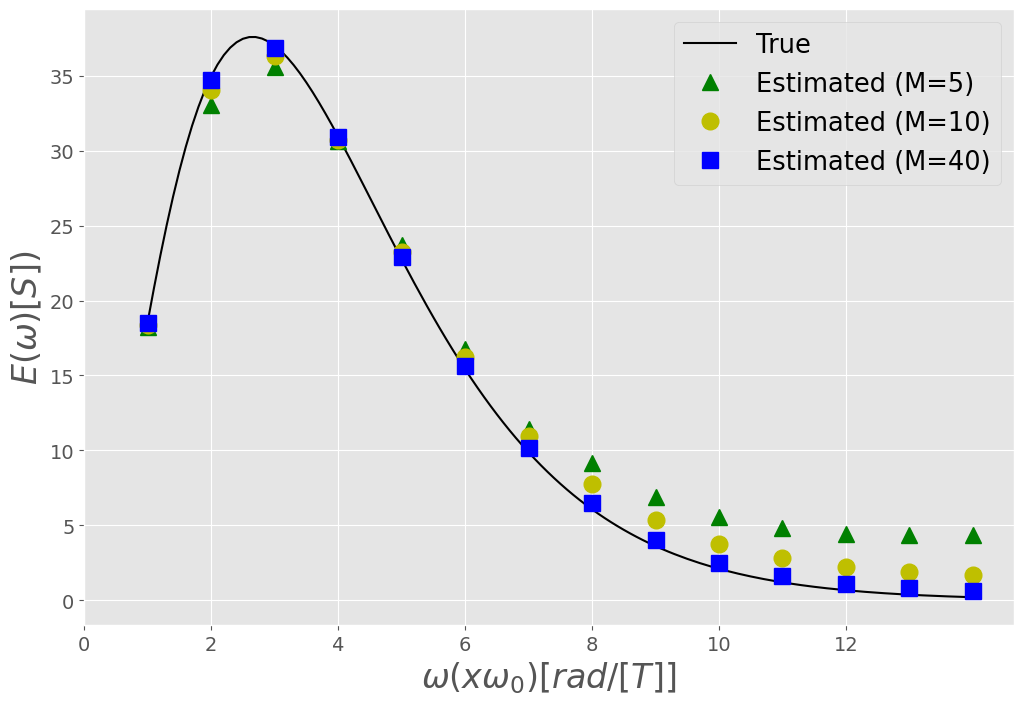

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14    

plt.plot( w1,spectPn3,'k',omega, Rvec[:,0] ,'g^',omega,Rvec[:,1] ,'yo',omega,Rvec[:,2] ,'bs', markersize = 12) 
plt.xlabel('$\omega( x\omega_0)[rad/[T]]$', fontsize=24)
plt.xticks(np.arange(0, N*wr(1), step=2*T*wr(1)),np.arange(0,N,step=2*T))
plt.legend(['True','Estimated (M=5)','Estimated (M=10)','Estimated (M=40)'],\
          prop={'size': 18.5})
plt.ylabel('$E(\omega) [S]$)', fontsize=24)
####plt.show()

plt.savefig('Fig2.pdf') 